# **Load Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline  # chaining step together

import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
df = pd.read_csv('bank-full.csv', sep = ';')
df.head(4)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no


# **Data Understanding**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Check the duplicate

In [4]:
print(df.duplicated().value_counts())

False    45211
dtype: int64


## Check the Missing value

In [5]:
df.isnull().values.any()

False

## Descriptive Overview

In [6]:
round(df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.94,10.62,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.27,3044.77,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.81,8.32,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.16,257.53,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.76,3.10,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.20,100.13,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.58,2.30,0.0,0.0,0.0,0.0,275.0


# Target value Modification

In [7]:
df.rename(columns = {'y':'deposit'}, inplace = True)

In [8]:
df['deposit'] = df['deposit'].map( {'yes':1 ,'no':0}) 

df['deposit'].value_counts()/len(df)

0    0.883015
1    0.116985
Name: deposit, dtype: float64

In [9]:
df.groupby('deposit').mean()

,age,balance,day,duration,campaign,pdays,previous
deposit,,,,,,,
0,40.838986,1303.714969,15.892290,221.182806,2.846350,36.421372,0.502154
1,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354


**Observations**:

- The average Age & Balance of customers who have the term deposit is **higher** than the customers who didn’t.


- The Day seems not impact on target. need to be drop in next part.


- The Avg duration of call with those getting deposit is higher than the customers who didnt get the deposit.


- The campaigns are lower for customers who get the term deposit, means less contact probabaly increase the ratio of deposit.


- The pdays is lower for the customers who get the deposit.which make sense, since they can remember easier as fewer days passed


- The Previous( number of contacts performed before this campaign ) is higher for those get deposit.

# Target value Distribution

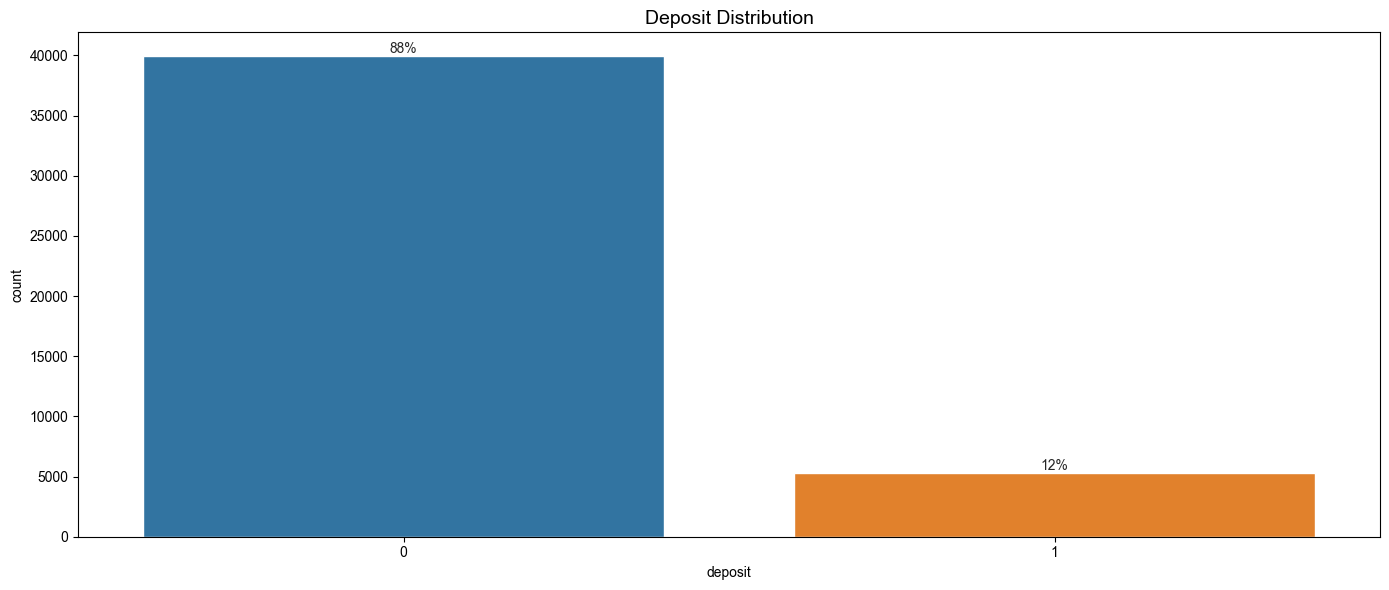

In [10]:
fig, ax = plt.subplots(figsize=(14, 6))#size
sns.set_style('whitegrid')

sns.countplot(x=df['deposit'], ax=ax)

abs_vals = df['deposit'].value_counts()
rel_vals = df['deposit'].value_counts(normalize=True) * 100
labels = [f'{p[1]:.0f}%' for p in zip(abs_vals, rel_vals)]

ax.bar_label(container=ax.containers[0], labels=labels)
ax.set_title('Deposit Distribution', fontsize=14)
plt.tight_layout()

- The number of customers who have subscribed deposits is 5289 (12%)  


- The number of customers who do not subscribe deposits is 39922 (88%)


- The data is imbalanced and skewed(lead to false negatives)

## Categorical features Overview

### Deposit by Job,Marital and Education

Text(0.5, 1.0, 'Education Distribution')

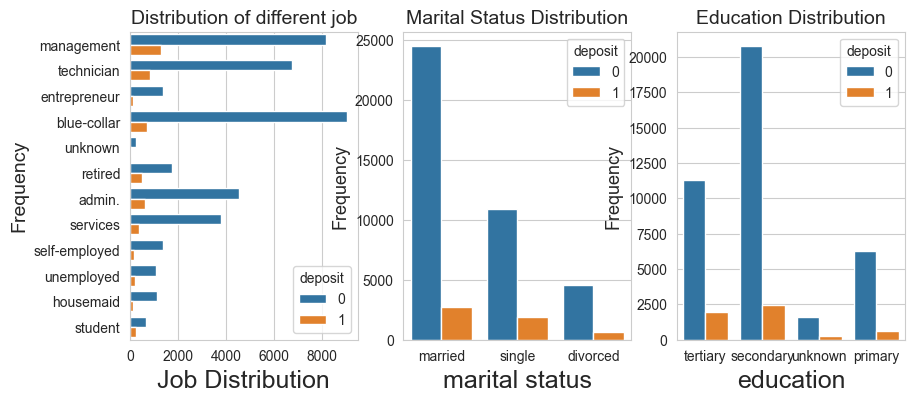

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize = (10, 4))

ax = sns.countplot(y='job', hue='deposit', data=df, ax=ax1)
ax.set_xlabel('Job Distribution', fontsize=18)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Distribution of different job', fontsize = 14)

ax = sns.countplot(x='marital', hue='deposit', data=df, ax=ax2)
ax.set_xlabel('marital status', fontsize=18)
ax.set_ylabel('Frequency', fontsize = 13)
ax.set_title('Marital Status Distribution', fontsize = 14)

ax = sns.countplot(x='education', hue='deposit', data=df, ax=ax3)
ax.set_xlabel('education',fontsize = 18)
ax.set_ylabel('Frequency', fontsize = 13)
ax.set_title('Education Distribution', fontsize = 14)

### Deposit by Default,Housing and Loan

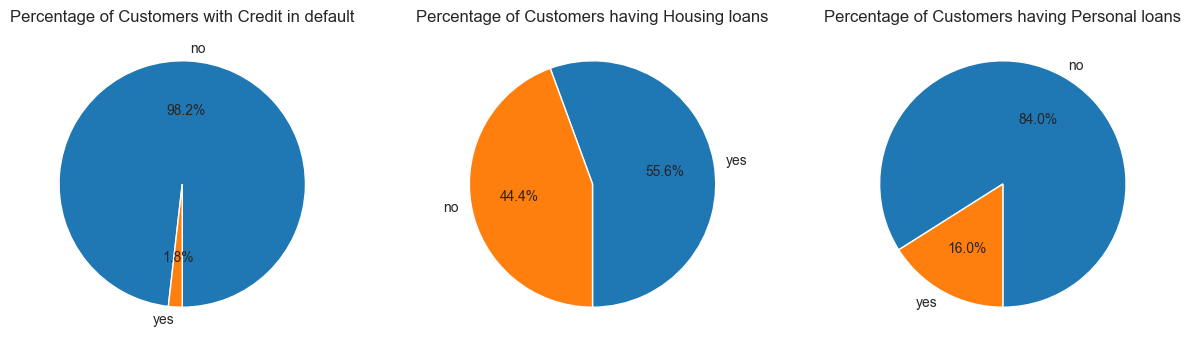

In [12]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
labels =df['default'].value_counts().index
sizes = df['default'].value_counts()
plt.pie(sizes,labels=labels,autopct='%1.1f%%', startangle=270)
plt.title('Percentage of Customers with Credit in default',size = 12)

plt.subplot(1,3,2)
labels =df['housing'].value_counts().index
sizes = df['housing'].value_counts()
plt.pie(sizes,labels=labels,autopct='%1.1f%%', startangle=270)
plt.title('Percentage of Customers having Housing loans',size = 12)

plt.subplot(1,3,3)
labels =df['loan'].value_counts().index
sizes = df['loan'].value_counts()
plt.pie(sizes,labels=labels,autopct='%1.1f%%', startangle=270)
plt.title('Percentage of Customers having Personal loans',size = 12)
plt.show()

### Deposit by Contact, Month,Poutcome

Text(0.5, 1.0, ' outcome of the previous marketing campaign')

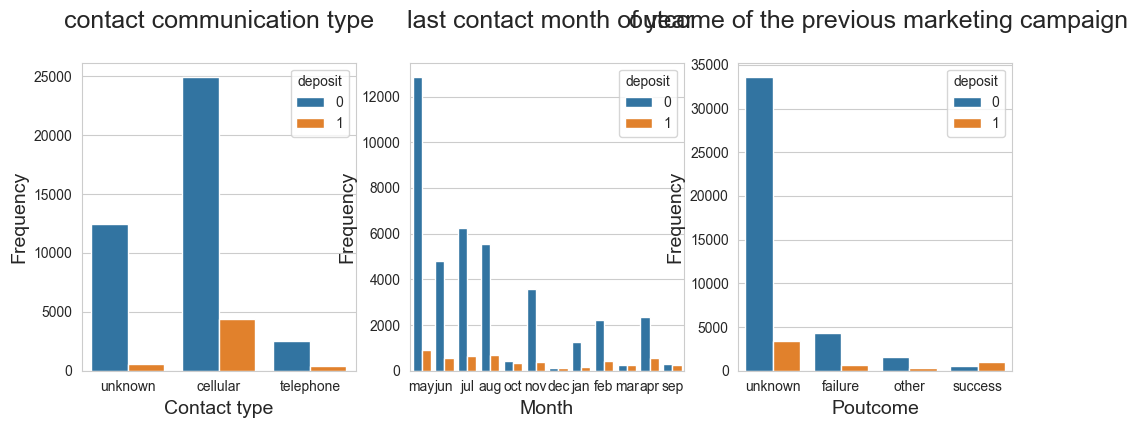

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize = (12, 4))

ax = sns.countplot(x='contact', hue='deposit', data=df, ax=ax1)
ax.set_xlabel('Contact type', fontsize=14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('contact communication type', fontsize = 18,pad=25)

ax = sns.countplot(x='month', hue='deposit', data=df, ax=ax2)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title(' last contact month of year', fontsize = 18,pad=25)

ax = sns.countplot(x='poutcome', hue='deposit', data=df, ax=ax3)
ax.set_xlabel('Poutcome',fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title(' outcome of the previous marketing campaign', fontsize = 18,pad=25)

## Categorical Features Overview in a for loop

In [14]:
#categorical_features = df.select_dtypes(include='object').drop('deposit').columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()

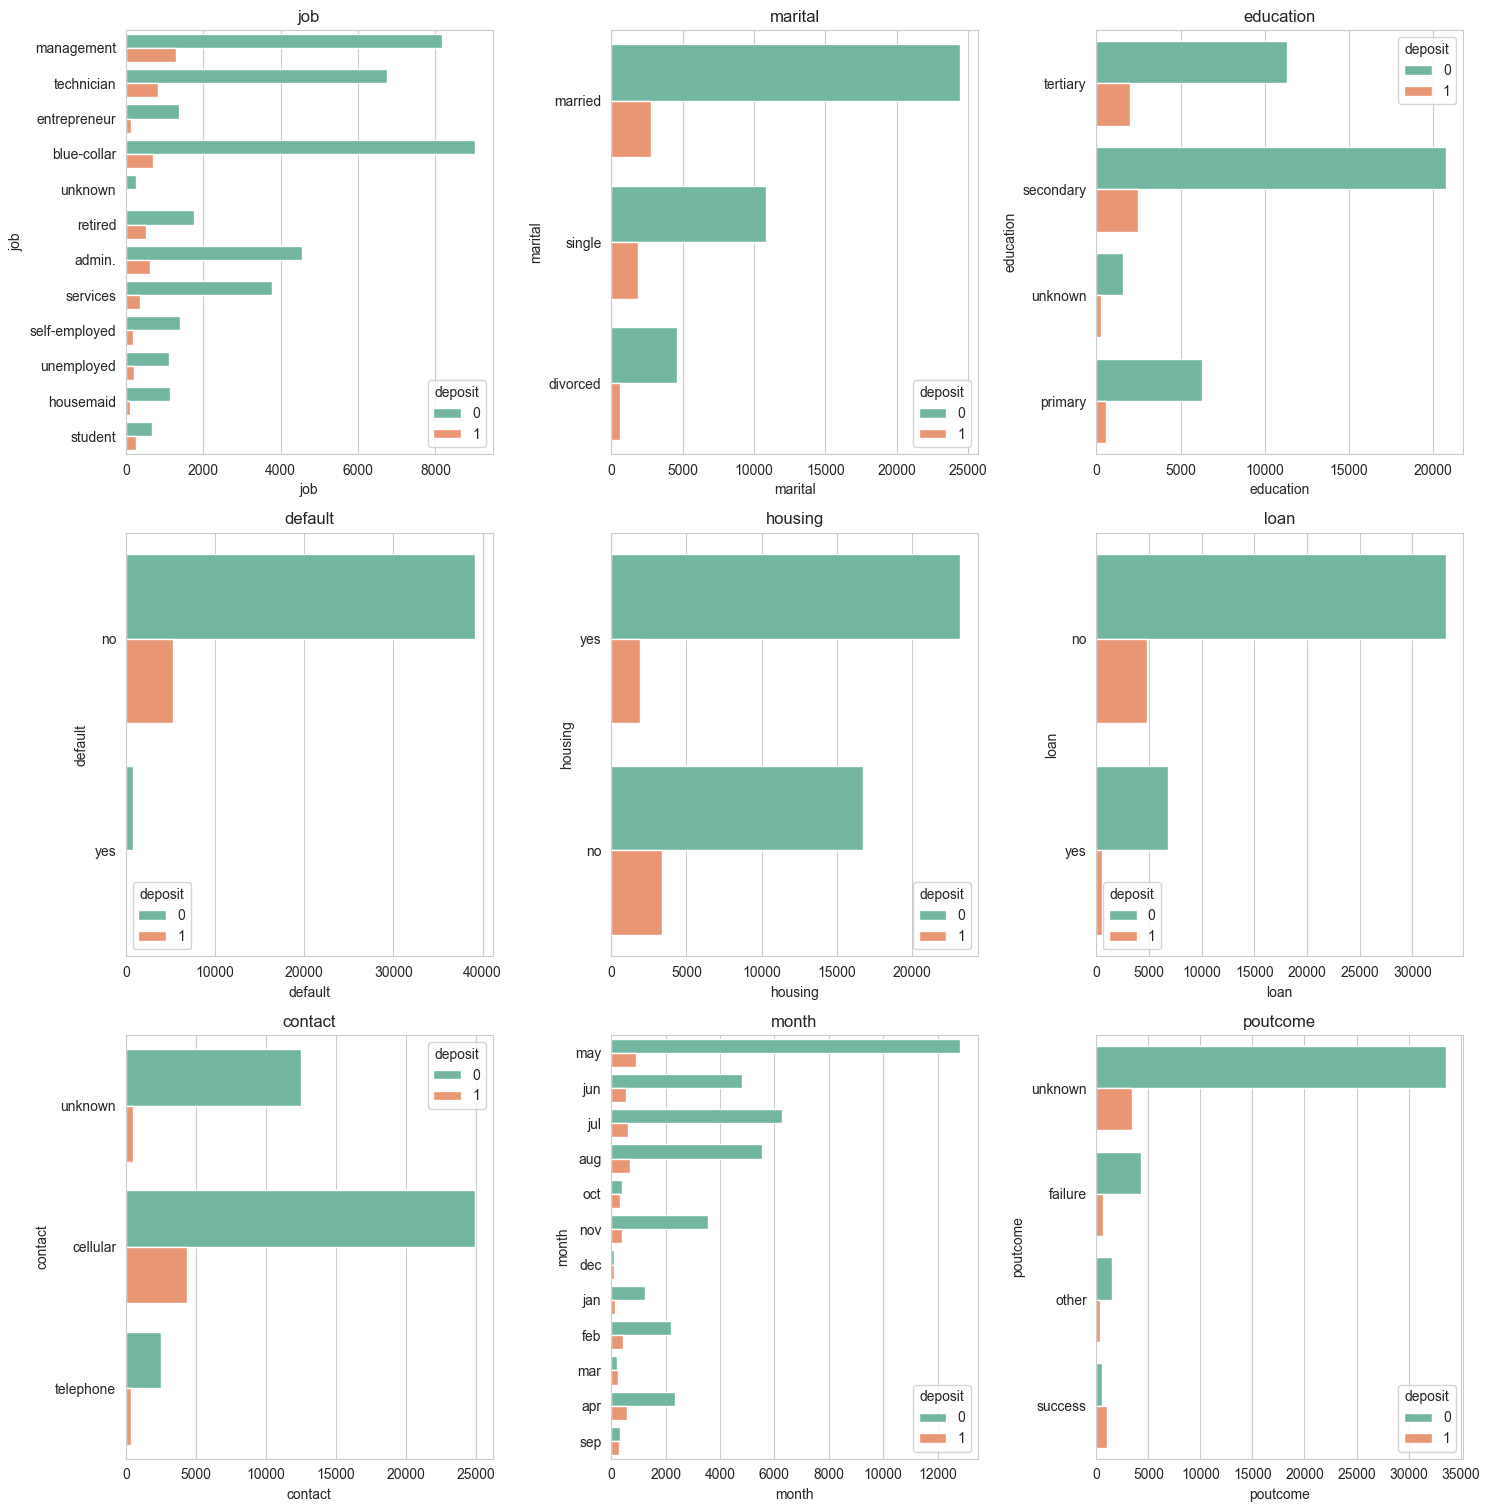

In [15]:
#categorical features
plt.figure(figsize=(15,60))
pos =1
for cat_feature in categorical_features:
    ax = plt.subplot(12,3,pos)
    sns.countplot(y=cat_feature, data=df ,hue='deposit',palette = 'Set2')
    plt.xlabel(cat_feature)
    plt.title(cat_feature)
    pos+=1
plt.tight_layout()

## Function for plotting each feature

In [16]:
# Define a function to create a bar label on categorical plots

def label(data,feature,x,y):
    """
    Description: This function would plot each categorical feature and their labels respectively.
    
    data : dataframe
    feature : categorical feature
    x,y: size of plot 
    
    output: plot a countplot
    """
    plt.figure(figsize=[x,y])
    sns.set_style('whitegrid')
    fig_deposit = sns.countplot(x=feature, hue='deposit', data = data, palette='pastel')
    fig_deposit.bar_label(fig_deposit.containers[0])
    fig_deposit.bar_label(fig_deposit.containers[1])

## Function to calculate the percentage of deposit (subscribtion)

In [17]:
# Define a function to calculate the ratio in respect of deposit

def Ratio(feature):
    """
    This function would calculate the percentage of getting deposit .i.e., sum of deposit divided by count.
    
    return: dep as a dictionary 
    """
    dep = df.groupby([feature])['deposit'].agg(['count', 'sum', 'mean']) 
    dep = dep.rename(columns = {'count':'Nr of Client','sum':'DeptSum', 'mean':'Ratio'}).sort_values(by='Ratio',ascending=False)
    return dep

# Univariate Analysis of Categorical Features

- Analysis each categorical feature individually

## Job 

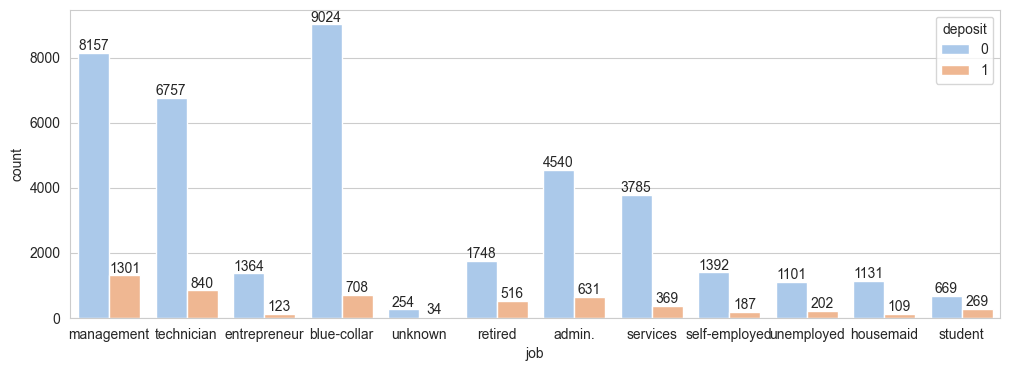

In [18]:
label(df,'job',12,4)

In [19]:
Ratio('job')

,Nr of Client,DeptSum,Ratio
job,,,
student,938,269,0.286780
retired,2264,516,0.227915
unemployed,1303,202,0.155027
management,9458,1301,0.137556
admin.,5171,631,0.122027
self-employed,1579,187,0.118429
unknown,288,34,0.118056
technician,7597,840,0.110570
services,4154,369,0.088830


- students and retired customers have higher ratio rates among other jobs.

## Marital

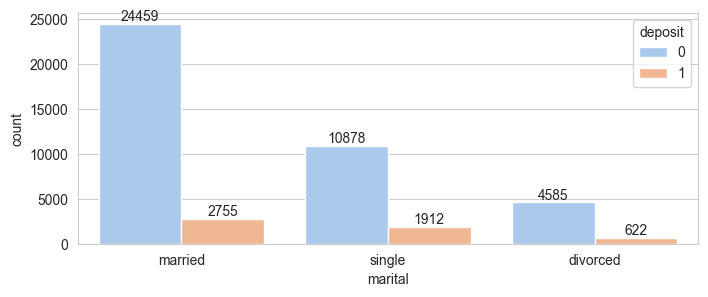

In [20]:
label(df,'marital',8,3)

In [21]:
Ratio('marital')

,Nr of Client,DeptSum,Ratio
marital,,,
single,12790,1912,0.149492
divorced,5207,622,0.119455
married,27214,2755,0.101235


- Even though the number of married customers is more, the single customer is close to getting the term deposit. 

## Education

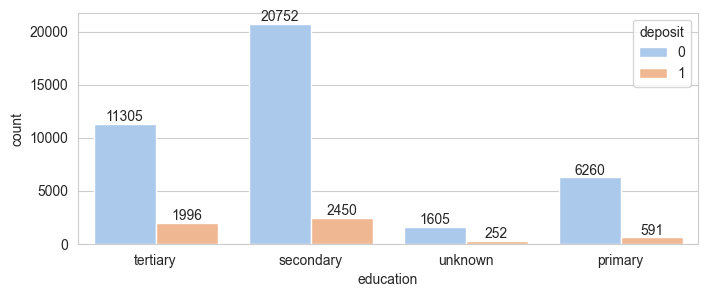

In [22]:
label(df,'education',8,3)

In [23]:
Ratio('education')

,Nr of Client,DeptSum,Ratio
education,,,
tertiary,13301,1996,0.150064
unknown,1857,252,0.135703
secondary,23202,2450,0.105594
primary,6851,591,0.086265


- clients with secondary levels are the highest proportion; however,
- tertiary level has the highest deposit customer percentage (15%).
- The trends go down with lower education. So the higher the education, the greater the tendency of a person to subscribe.

## Default

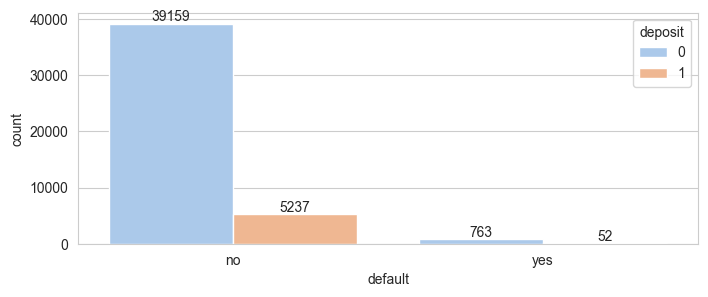

In [24]:
label(df,'default',8,3)

In [25]:
Ratio('default')

,Nr of Client,DeptSum,Ratio
default,,,
no,44396,5237,0.117961
yes,815,52,0.063804


## Housing

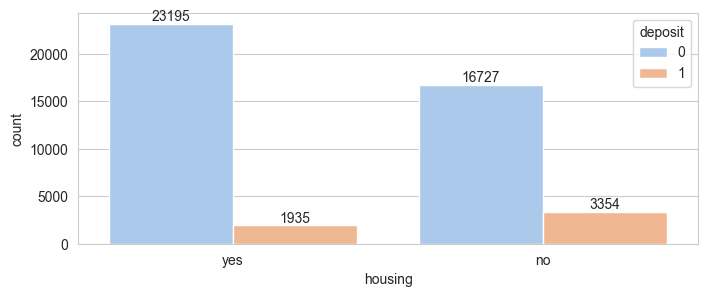

In [26]:
label(df,'housing',8,3)

In [27]:
Ratio('housing')

,Nr of Client,DeptSum,Ratio
housing,,,
no,20081,3354,0.167024
yes,25130,1935,0.077000


## Loan

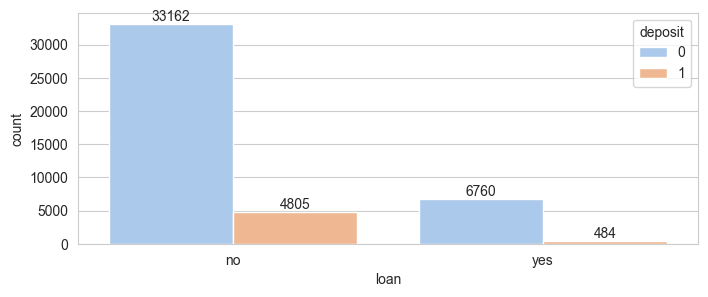

In [28]:
label(df,'loan',8,3)

In [29]:
Ratio('loan')

,Nr of Client,DeptSum,Ratio
loan,,,
no,37967,4805,0.126557
yes,7244,484,0.066814


- Clients with no Credit in default or not having Housing loans or not having Personal loans have **twice** the tendency to subscribe to a deposit compared to ones with default or loans.

## Contact

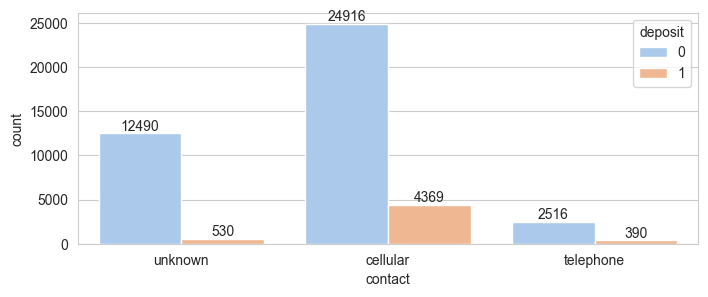

In [30]:
label(df,'contact',8,3)

In [31]:
Ratio('contact')

,Nr of Client,DeptSum,Ratio
contact,,,
cellular,29285,4369,0.149189
telephone,2906,390,0.134205
unknown,13020,530,0.040707


- Contacting clients by cellular or telephone does not dramatically impact the deposit in the end.
- Clients contacted by unknown contacts are more likely to **not** deposit; only 4% of them deposited.
- Should check what unknown means here

## Month

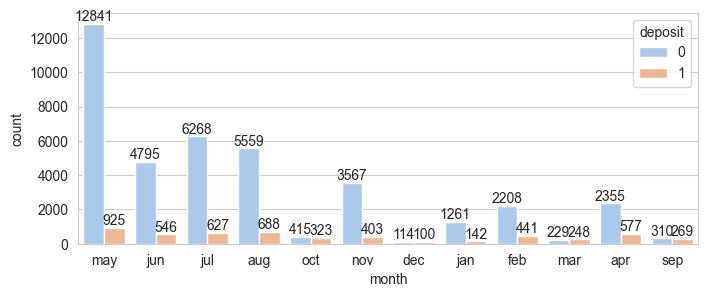

In [32]:
label(df,'month',8,3)

In [33]:
Ratio('month').T

month,mar,dec,sep,oct,apr,feb,aug,jun,nov,jan,jul,may
Nr of Client,477.000000,214.00000,579.000000,738.000000,2932.000000,2649.000000,6247.000000,5341.000000,3970.000000,1403.000000,6895.000000,13766.000000
DeptSum,248.000000,100.00000,269.000000,323.000000,577.000000,441.000000,688.000000,546.000000,403.000000,142.000000,627.000000,925.000000
Ratio,0.519916,0.46729,0.464594,0.437669,0.196794,0.166478,0.110133,0.102228,0.101511,0.101212,0.090935,0.067195


- Although the number of clients was high in **May** in compare with other months but the **deposit subscribtion** was the **lowest**

## poutcome

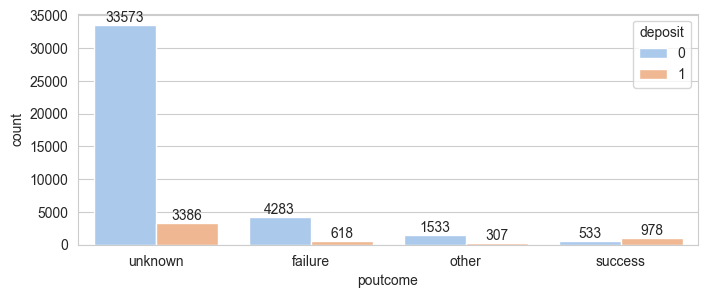

In [34]:
label(df,'poutcome',8,3)

In [35]:
Ratio('poutcome')

,Nr of Client,DeptSum,Ratio
poutcome,,,
success,1511,978,0.647253
other,1840,307,0.166848
failure,4901,618,0.126097
unknown,36959,3386,0.091615


- if the outcome of the previous marketing campaign is successful we can see a higher deposit rate


- Customers with unknown poutcome  are most likely to open term deposit.


- Although the meaning of unknown is not defined in the dataset but as the value is high, we will keep it  as it might show some patterns


- we will segment the poutcome to two category: Success and not success

# Bivariate Analysis of Categorical Features

- In this Section, we focus on customers charachteristic, who say **'Yes'** to the Subscription


- How professions have influenced whether a person would subscribe?


- How type of contact can play a role in getting a term deposit?


- Does any particular month(s) can have an impact on subscribing a deposit?


- Does the previous campaign can lead to more subscribtion or not?


- How different Marital Status and different level of education can impact on subscribing  aterm deposit? 

- **job**:  **Students & Retired** are more likely to subscribe a term deposit respectively.**blueCollar** are the lowest in subcribing the term deposit.

In [36]:
df1 = df.groupby(['job','deposit']).count().reset_index()
df1.loc[:,'percentage'] = list(df1.groupby(['job'])['age'].apply(lambda x: round(x*100/x.sum())))
df1.loc[:,'percentage'] 
df1 = df1[df1.deposit==1]
#df1.percentage

<Axes: xlabel='job', ylabel='percentage'>

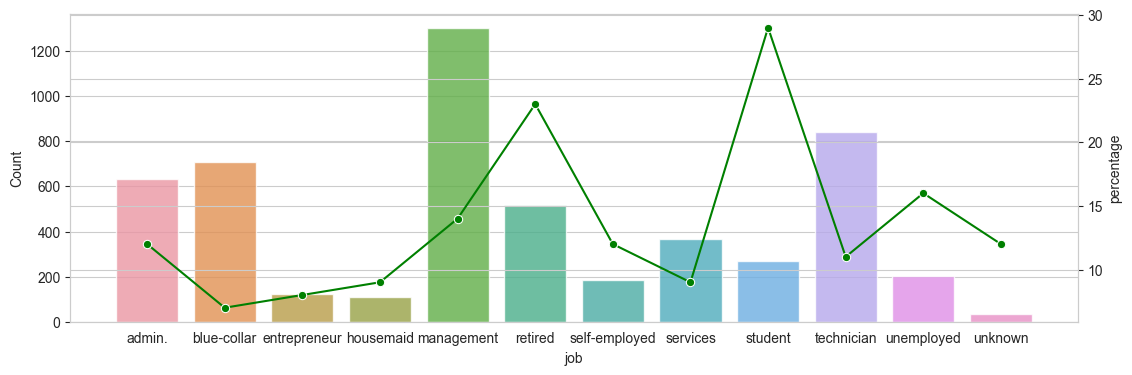

In [37]:
fig, ax1 = plt.subplots(figsize=(13,4))

#sns.countplot(data = df, x='job', alpha=0.8, ax=ax1)
sns.barplot(data = df1, x='job', y= 'age', alpha=0.8, ax=ax1)
plt.ylabel('Count')

ax2 = ax1.twinx()
sns.lineplot(data =df1, x='job', y='percentage', marker='o', sort = True,ax=ax2,color='green')

- **Contact**: Contacting through **Cellular** leads to subscribe abit  more deposit in compare to telephone but not dramatically different.



- On the other hand, customers contacted by unknown contacts are more likely to **not** deposit; only 4% of them deposited. 
  the unknown does not define in the dataset.

In [38]:
df2 = df.groupby(['contact','deposit']).count().reset_index()
df2.loc[:,'percentage'] = list(df2.groupby(['contact'])['age'].apply(lambda x: round(x*100/x.sum())))
df2 = df2[df2.deposit==1]

<Axes: xlabel='contact', ylabel='percentage'>

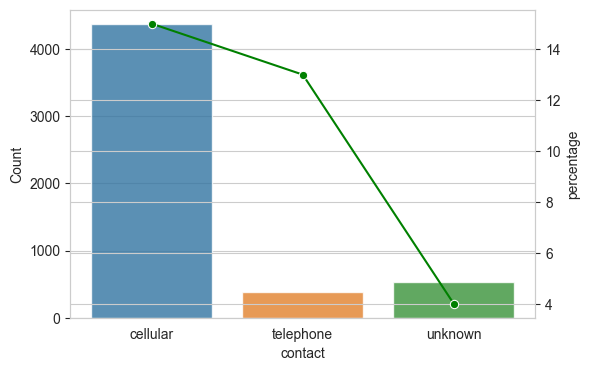

In [39]:
fig, ax1 = plt.subplots(figsize=(6,4))

sns.barplot(data = df2, x='contact',y='age' ,alpha=0.8, ax=ax1)
plt.ylabel('Count')
ax2 = ax1.twinx()
sns.lineplot(data =df2, x='contact', y='percentage', marker='o', sort = True,ax=ax2,color='green')

 - **Month**: **March** & **December** have the **highest** ratio of subscribing a term deposit and **May** is the **lowest** month, unlike the number of customers are much more in May but the subscribtion is the lowest.

In [40]:
df3 = df.groupby(['month','deposit']).count().reset_index()
df3.loc[:,'percentage'] = list(df3.groupby(['month'])['age'].apply(lambda x: round(x*100/x.sum())))
df3 = df3[df3.deposit==1]

Text(0.5, 0, 'Month')

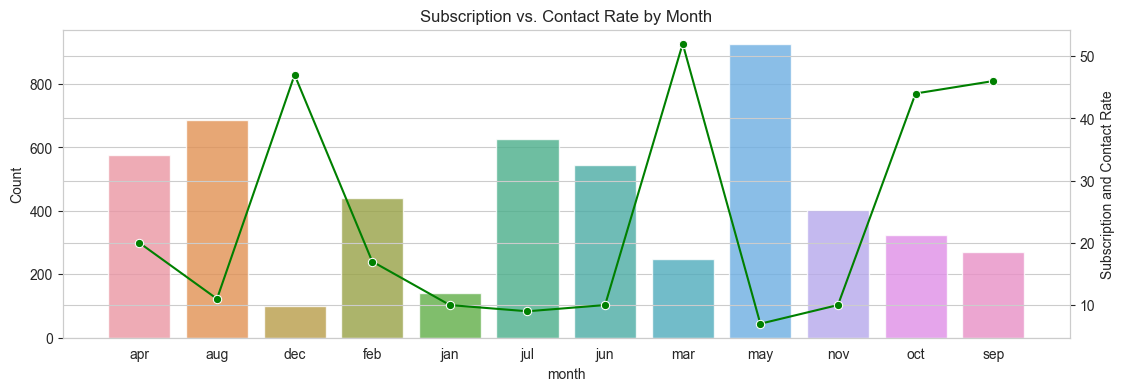

In [41]:
fig, ax1 = plt.subplots(figsize=(13,4))

sns.barplot(data = df3, x='month',y='age', ax=ax1,alpha=0.8)
plt.ylabel('Count')

ax2 = ax1.twinx()
sns.lineplot(data =df3, x='month', y='percentage', marker='o', sort = True,ax=ax2, color='green')

plt.title('Subscription vs. Contact Rate by Month')
plt.ylabel('Subscription and Contact Rate')
plt.xlabel('Month')

- The barplot displays the bank's contact rate in each month 


- The line chart displays the subscription rate in each month.


- One way to evaluate the effectiveness of the bank's marketing plan is to see whether these two chart have a similar trend over the same time horizon.


- The **successful previous campaign**  lead to a higher percentage of clients who accepts the subscription for a term deposit.

In [42]:
df4 = df.groupby(['poutcome','deposit']).count().reset_index()
df4.loc[:,'percentage'] = list(df4.groupby(['poutcome'])['age'].apply(lambda x: round(x*100/x.sum())))
df4 = df4[df4.deposit==1]

<Axes: xlabel='poutcome', ylabel='percentage'>

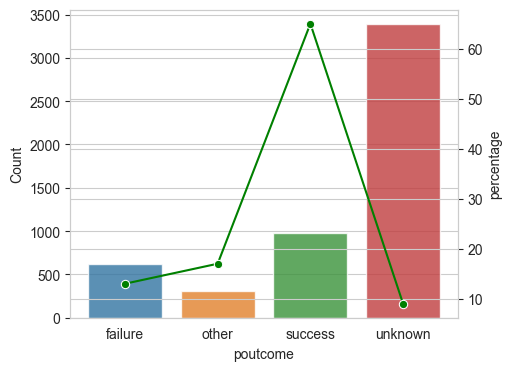

In [43]:
fig, ax1=plt.subplots(figsize=(5,4))

sns.barplot(data=df4, x='poutcome',y='age',alpha=0.8, ax=ax1)
plt.ylabel('Count')
ax2 =ax1.twinx()
sns.lineplot(data=df4,x='poutcome',y='percentage', marker='o', sort = True,ax=ax2,color='green')

- **Single** customers are 4% more likley to subsribe the term deposit.

In [44]:
df5 = df.groupby(['marital','deposit']).count().reset_index()
df5.loc[:,'percentage'] = list(df5.groupby(['marital'])['age'].apply(lambda x: round(x*100/x.sum())))
df5 = df5[df5.deposit==1]

<Axes: xlabel='marital', ylabel='percentage'>

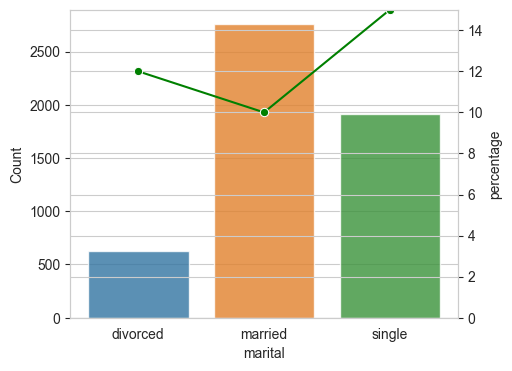

In [45]:
fig, ax1=plt.subplots(figsize=(5,4))

sns.barplot(data=df5, x='marital',y='age',alpha=0.8, ax=ax1)
plt.ylabel('Count')
ax2 =ax1.twinx()
ax2.set_ylim(0, 15)
sns.lineplot(data=df5,x='marital',y='percentage', marker='o', sort = True,ax=ax2,color='green')

- Customers with **Tertiary** level of education are two times more probabale to get the term deposit.

In [46]:
df6 = df.groupby(['education','deposit']).count().reset_index()
df6.loc[:,'percentage'] = list(df6.groupby(['education'])['age'].apply(lambda x: round(x*100/x.sum())))
df6 = df6[df6.deposit==1]

<Axes: xlabel='education', ylabel='percentage'>

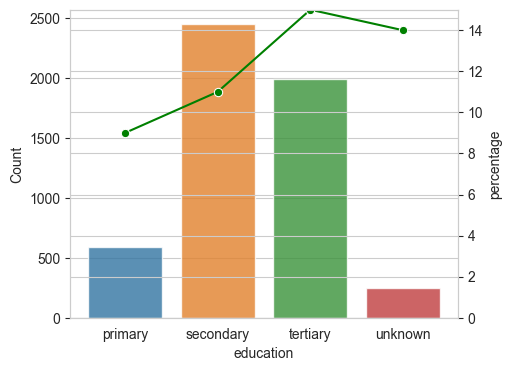

In [47]:
fig, ax1=plt.subplots(figsize=(5,4))
sns.barplot(data=df6, x='education',y='age',alpha=0.8, ax=ax1)
plt.ylabel('Count')
ax2 =ax1.twinx()
ax2.set_ylim(0, 15)
sns.lineplot(data=df6,x='education',y='percentage', marker='o', sort = True,ax=ax2,color='green')

#  Numerical Features Overview

# Univariate Analysis of Numerical Features



In [48]:
Numeric_data = df.select_dtypes(include='number').columns.tolist()
#df[Numeric_data]

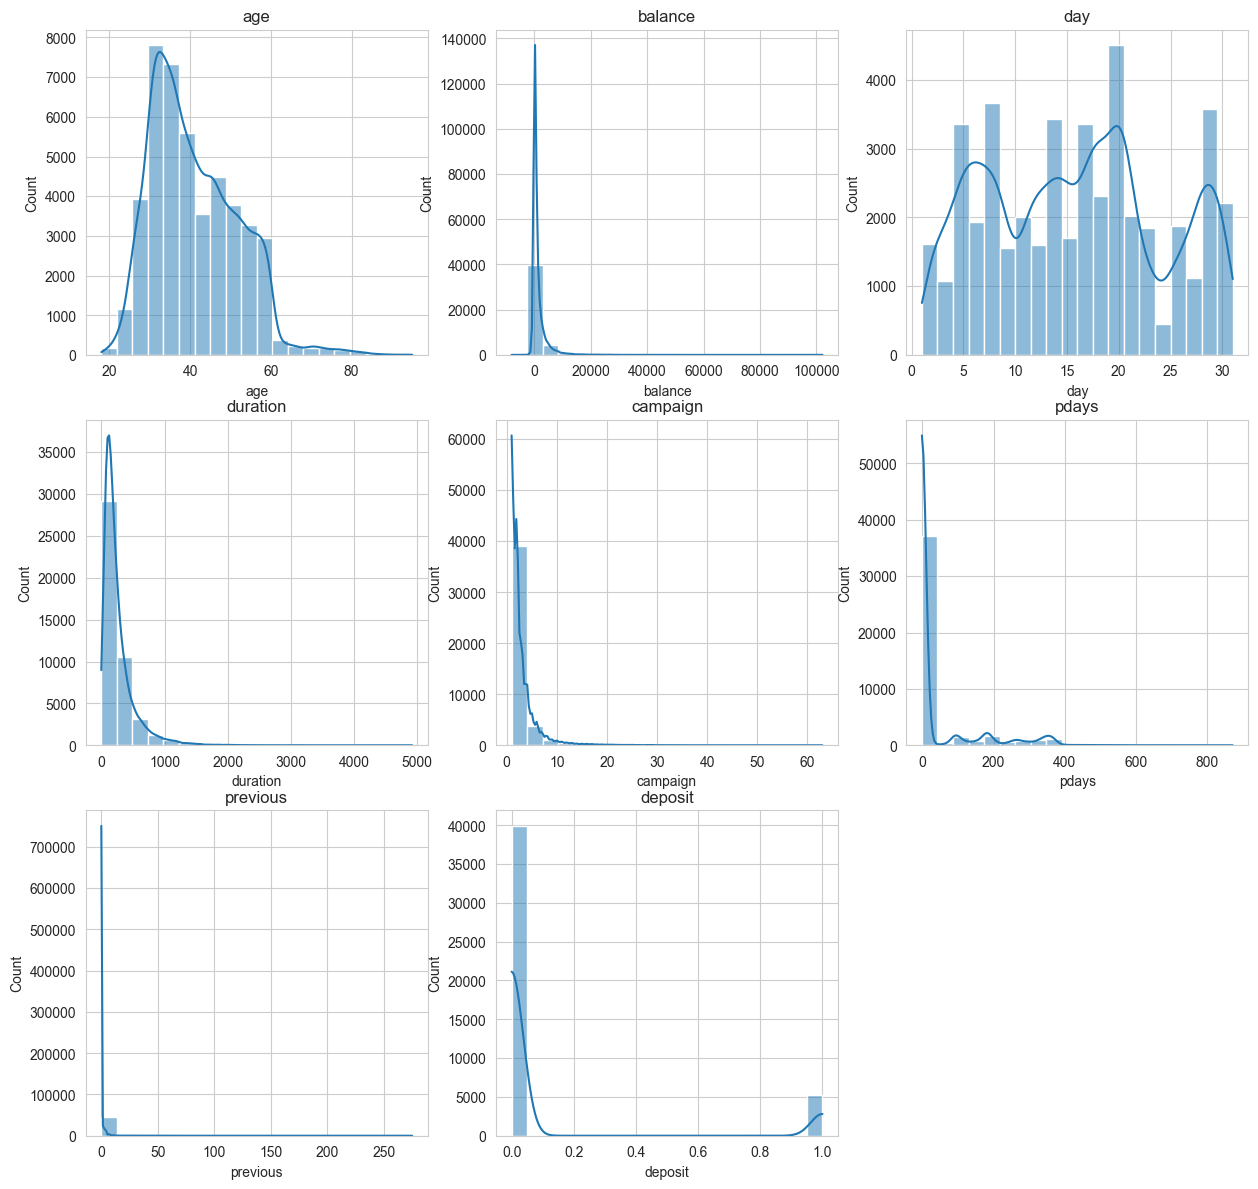

In [49]:
#Numerical features overview 2
plt.figure(figsize=(15,60))

plotnum =1
for i in Numeric_data:
    ax = plt.subplot(12,3,plotnum)
    #sns.histplot(data=df,x=i,kde=True, bins=20)
    sns.histplot(df[i],kde=True, bins=20)
    plt.xlabel(i)
    plt.title(i)
    plotnum+=1
plt.show()

- Most of the numerical features (Balance, duration, compaign, pdays and previous) have **right skewed** and have some **outliers**  which need to be removed in the next part. Age, Days almost normally distributed.


- Most of the customers lie between age of 20 and 60


- Numeric features have **different scales**, need to be scale values before building ML model.

#  Bivariate Analysis of Numerical Features

- In this section we look at the impact of some Bank customer data like age, balance, ... on subsribing a term deposit.



- Here we check the relation of each numeric variable with other variable and the target value

## Age

### Age Distribution in Getting Deposit Vs Not Getting Deposit

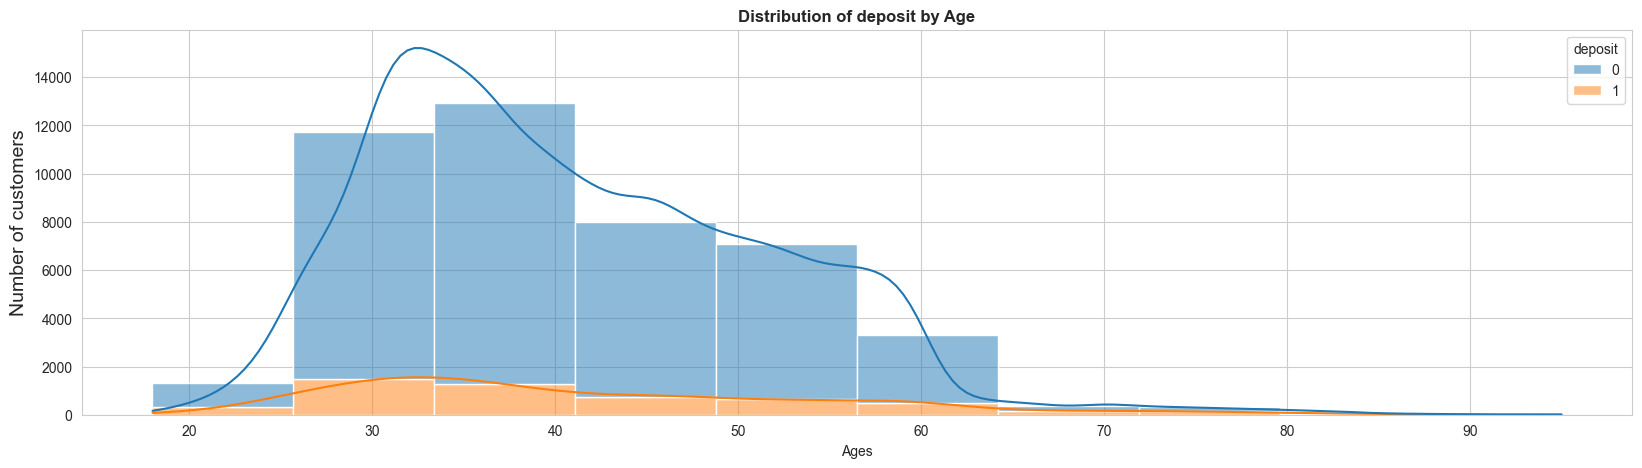

In [50]:
fig = plt.figure(figsize= (20,5))
dep_by_age = sns.histplot(data = df, x = 'age', hue = 'deposit',multiple='stack', bins=10,kde=True,element='bars')

dep_by_age.set_ylabel('Number of customers',fontsize=14)
dep_by_age.set_xlabel('Ages')
dep_by_age.set_title('Distribution of deposit by Age',weight='bold')
plt.show()

**Observation**:


    
- Deposit starts at the age of 20+ and peak is between 30-50. 


- Frequently, deposit age of getting a deposit or not is 35.


- in addition Non-deposit age is between 30-50 years, with a mean is around 35-40 years

## binning the age to get more insight 

In [51]:
bins = [18, 30, 40, 60, 95]
labels = ['Youth', 'Young Adults', 'Mid-age Adults', 'Older']
df['agerange'] = pd.cut(df.age, bins=bins, labels = labels, include_lowest = True)
df.drop(columns = 'age')

,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,agerange
0,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,Mid-age Adults
1,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,Mid-age Adults
2,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,Young Adults
3,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,Mid-age Adults
4,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,Young Adults
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1,Mid-age Adults
45207,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1,Older
45208,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1,Older
45209,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0,Mid-age Adults


In [52]:
df.agerange.value_counts(normalize=True)

Mid-age Adults    0.427020
Young Adults      0.391210
Youth             0.155493
Older             0.026277
Name: agerange, dtype: float64

In [53]:
Ratio('agerange')

,Nr of Client,DeptSum,Ratio
agerange,,,
Older,1188,502,0.422559
Youth,7030,1145,0.162873
Young Adults,17687,1812,0.102448
Mid-age Adults,19306,1830,0.094789


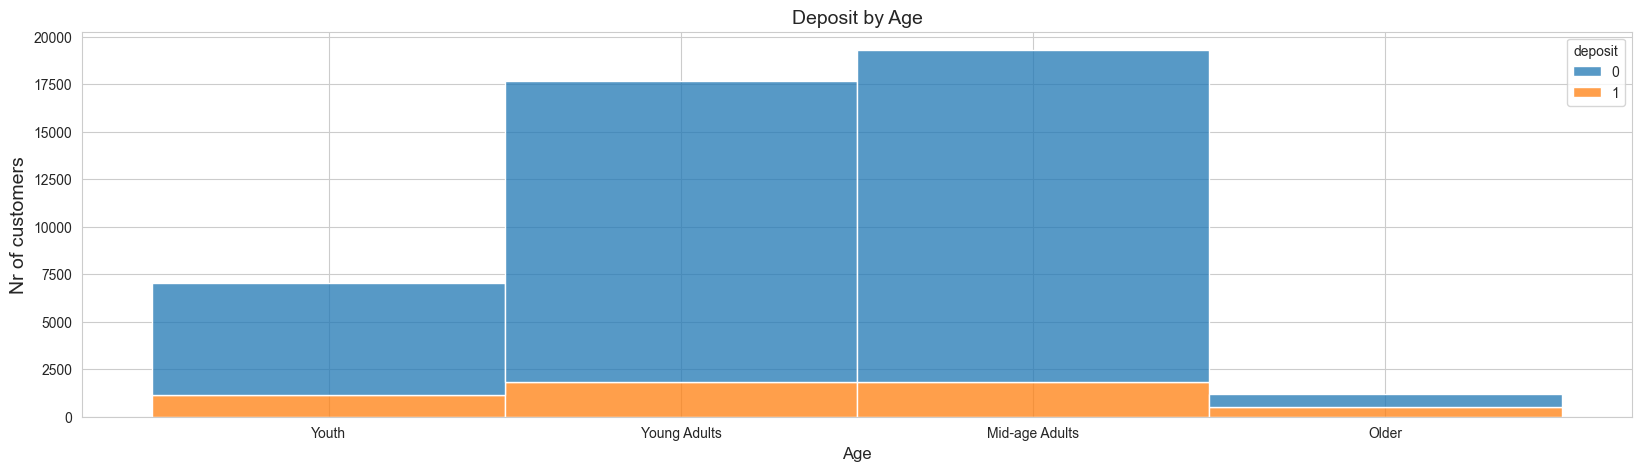

In [54]:
plt.figure(figsize=(20,5))
bins = [18, 30, 40, 60, 95]

age_range = sns.histplot(x = df['agerange'], hue = df['deposit'], multiple="stack",bins=bins)
age_range.set_ylabel('Nr of customers', fontsize = 14)
age_range.set_xlabel('Age', fontsize = 12)
age_range.set_title('Deposit by Age', fontsize = 14)
plt.show()

**Observation**

- target the **youngest** and the **oldest** instead of the middle-aged


-  All above graphs indicate that customers with a age of 60+ have the highest subscription rate. around 42%


-  About 17% of the subscriptions came from the clients aged between 18 to 30.


- Most client are Young and Middle-Aged People and they have not so high deposit percentages. 11% and 9% respectively.


- Term deposits, as the least risky investment tool, are more preferable to the eldest.


- Results show that the bank focused its marketing efforts on the **middle-aged group**, which returned **lower subscription rates** than the younger and older groups. Thus, to make the marketing campaign more effective, the bank should target younger and older clients in the future.

## Distribution of age by job

Text(0.5, 1.0, 'Jobs by Age')

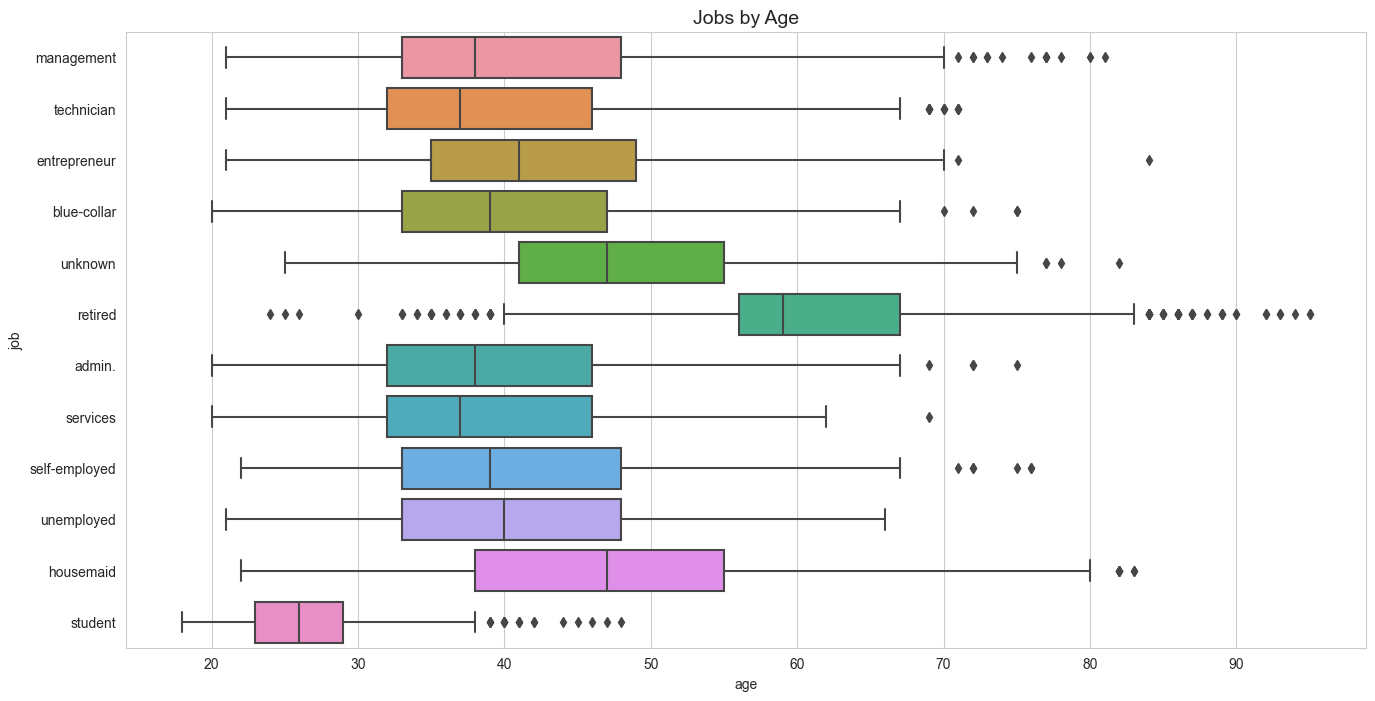

In [55]:
plt.figure(figsize=(16,8))
sns.set_style('whitegrid')
ax= sns.boxplot(x='age',y='job',data=df)
ax.set_title('Jobs by Age', fontsize = 14)

- All the job are almost around 35-55
- students between 25-30
- Retired are above 55

# Balance

# Distribution of age and balance

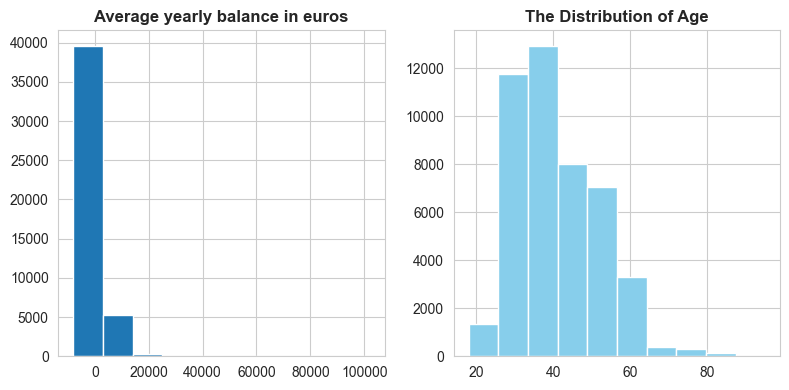

In [56]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize = (8, 4))

ax1.hist(df['balance'])
ax1.set_title('Average yearly balance in euros',weight='bold')

ax2.hist(df['age'], color = 'skyblue')
ax2.set_title('The Distribution of Age',weight='bold')

plt.tight_layout() 
plt.show()

**The distribution of balance** :

- The average yearly balance of customers given is diverse and quite low, which is mostly around €1400 per year.


- The distribution of balance has a **huge standard deviation** relative to the mean, suggesting large variabilities in customers' balance levels.


- The outliers must be removed in the next step (scaling can be done with a min-max scaler).


**The distribution of age** :

- Customers have an extensive age range, from 18 to 95 years old. However, a majority of customers called is in the age of 30s and 40s 



- The distribution of customer age is fairly normal with a small standard deviation.

# Balance & Age

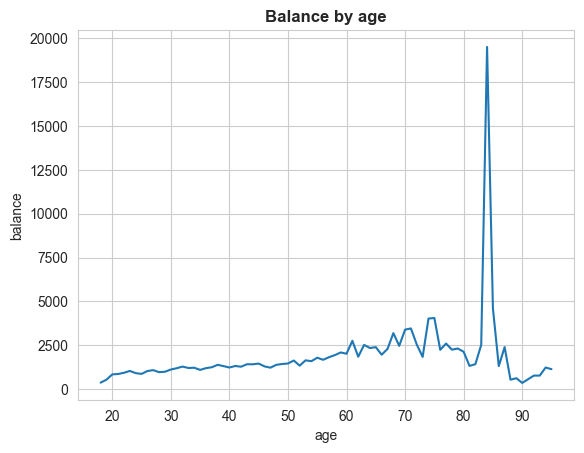

In [57]:
fig.set_size_inches(10,5)
plt.title('Balance by age',weight='bold')
plt.xlabel('age')
plt.ylabel('balance') 

plt.plot(df.groupby('age').mean()['balance'])

- Over the age of 60, Customers tend to have a bit higher balance, mostly around 5,000 euros. 


- This is due to the fact that most people retire after 60 and no longer have a reliable income source.



- Balance highly varied across age

In [58]:
# df.groupby('age').mean()['balance'].to_frame().sort_values(by='age',ascending=False)

# Balance & Job

Text(0.5, 1.0, 'Distribution of balace by Job')

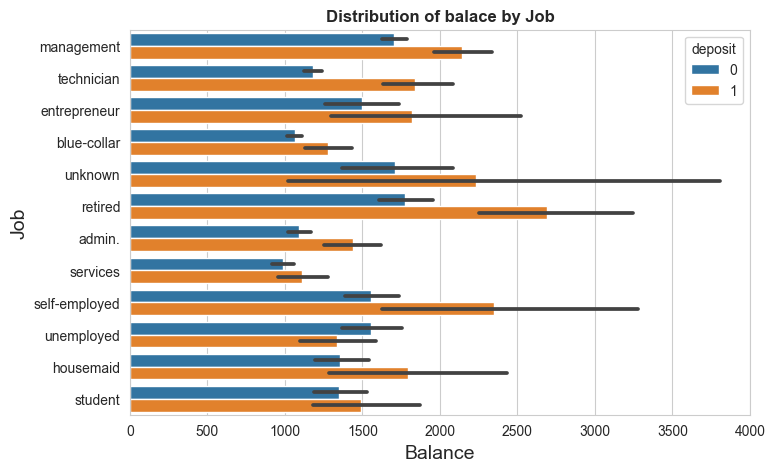

In [59]:
plt.figure(figsize=[8,5])

sns.barplot(data=df,y='job',x='balance',hue='deposit')

plt.xlabel('Balance',fontsize=14)
plt.ylabel('Job',fontsize=14)
plt.title('Distribution of balace by Job',weight='bold')

In [60]:
df.groupby(['job'])['balance'].mean().to_frame().sort_values(by='balance',ascending=False).T

job,retired,unknown,management,self-employed,unemployed,entrepreneur,housemaid,student,technician,admin.,blue-collar,services
balance,1984.215106,1772.357639,1763.616832,1647.970868,1521.745971,1521.470074,1392.395161,1388.060768,1252.632092,1135.838909,1078.826654,997.088108


- According to the graph, **Retired customers** have the **highest balance** value whereas the lowest value is occupied by those who do services.


- It is significant that people who holds **Management** position are **higher earners**, while administrators, blue-collar workers and services staff generally have low income.

<Axes: xlabel='balance', ylabel='job'>

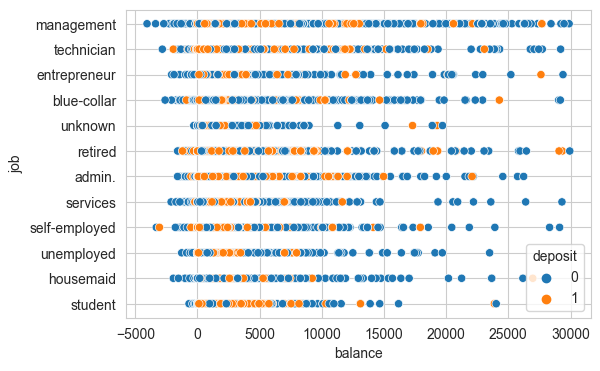

In [61]:
plt.figure(figsize=[6,4])
sns.scatterplot(data=df, y='job', x= df['balance'].loc[(df['balance']>=-5000)&(df['balance']<=30000)], hue='deposit')

## Balance & Education

Text(0.5, 1.0, 'Distribution of Education by Balance')

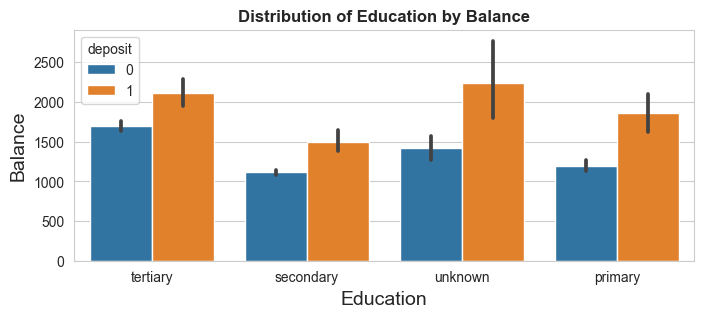

In [62]:
plt.figure(figsize=[8,3])
sns.set_style('whitegrid')
sns.barplot(data=df,y='balance',x='education',hue='deposit')


plt.xlabel('Education',fontsize=14)
plt.ylabel('Balance',fontsize=14)
plt.title('Distribution of Education by Balance',weight='bold')

In [63]:
Ratio('education')

,Nr of Client,DeptSum,Ratio
education,,,
tertiary,13301,1996,0.150064
unknown,1857,252,0.135703
secondary,23202,2450,0.105594
primary,6851,591,0.086265


- Apart from unknown group, which is not clear from dataset why it's called unknown, The Higher Education the higher balance 


- Cutomers with secondary levels are the highest proportion; however, tertiary level has the highest deposit customer percentage 

# Is there any correlation between subsribtion rate and balance?

- Retired customers have the highest balance value whereas the lowest value is occupied by those who do services.


- It is significant that people who holds Management position are higher earners, while administrators, blue-collar workers and services staff generally have low income.

In [ ]:
plt.figure(figsize=(15,6))
bal_dep = sns.kdeplot(x = df['balance'].loc[(df['balance']<=30000)&(df['balance']>=-5000)], hue = df['deposit'], multiple="stack")
bal_dep.set_ylabel('Number of customers', fontsize = 13)
bal_dep.set_xlabel('Balance (unit = euros)', fontsize = 13)
bal_dep.set_title('Deposit by Balance', fontsize = 14)
plt.show()

In [ ]:
def Balance_level(df):
    if (df['balance'] < 0) :
        return 'No Balance'
    elif (0 <= df['balance'] < 500):
        return 'Low Balance'
    elif (500 <= df['balance'] < 1500):
        return 'Average Balance'
    elif (1500 <= df['balance'] < 4000): 
        return 'High Balance'
    elif (4000 <= df['balance']): 
        return 'Very High Balance'
df['Balance_level'] = df.apply(Balance_level, axis = 1)

In [ ]:
df.groupby('Balance_level').Balance_level.count().plot(kind='bar',rot=45) 

In [ ]:
Ratio('Balance_level')

-  target customers with high balance



-  To identify the trend more easily, customers are categorized into **five** groups based on their levels of balance:
-  No Balance, Low Balance,Average Balance, High Balance,Very High Balance



- it is expected that there is a positive correlation between customers’ balance levels and subscription rate. customers with negative balances only returned a subscription rate of 0.05 % while customers with average or high balances had significantly higher subscription rates, nearly 16%.



- However, in this campaign, more than 50% of clients contacted only have a low balance level.


- In the future, the bank should shift its marketing focus to high-balance customers to secure more term deposits.

## Day

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10,4)
sns.histplot(x='day', data=df, hue = 'deposit', bins=30, ax=ax[0],kde = True, color ='y')
sns.boxplot(x='day',data=df, ax=ax[1],color ='b')

plt.xlabel('day')
plt.show()

In [ ]:
label(df,'day',8,4)
Ratio('day').T

- we will drop this feature as it's not add any information

# How the distribution of Duration (last contact duration, in seconds) can impact the subsribing ?

In [ ]:
sns.histplot(data=df,x='duration',kde=True, bins=20,hue='deposit',multiple='stack')

- The left-skewed plot indicates that most calls are relatively short. 


- Also, there is a large number of outliers, which need to take a log.

## Scale Transform the Duration

In [ ]:
plt.figure(figsize = [10, 5])

# left histogram: data plotted in natural units
plt.subplot(1, 2, 1)
bins = np.arange(0, 1500, 50)
#plt.hist(data = df, x = 'duration', bins = bins)
sns.histplot(data=df,x='duration',kde=True,hue='deposit',multiple='stack')
plt.xlim(0,1500)
plt.xlabel('values')

# right histogram: data plotted after direct log transformation
plt.subplot(1, 2, 2)

binsize = 0.1
bin_edges = 10 ** np.arange(0.5, np.log10(df['duration'].max())+binsize,binsize) # direct data transform

#plt.hist(df['duration'], bins = bin_edges)
sns.histplot(data=df,x='duration',kde=True,hue='deposit',multiple='stack')
plt.xscale('log')
tick_locs = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 4000] 
plt.xticks(tick_locs, tick_locs) # specify locations and labels 
plt.xlabel('log(values)')

- The distribution is still heavily skewed until 400 seconds.


- To analyze it easier I take the **log scale** to the data.duration to get a normal distribution


- The **majority** of the call duration lies in the range of 50 to 900 secs.

- this feature highly affects the output target (e.g., if duration=0, then deposit='no'). 


- the duration is not known before a call is performed. Also, after the end of the call, y(deposit) is known. 


- Thus, this input should only be included for benchmark purposes and discarded for the modeling section.

In [ ]:
# plot without outlier
fig = plt.figure(figsize=[4,2])
fig.set_size_inches(8,3)
sns.displot(data=df, x=df['duration'].loc[df['duration']<=3000], hue='deposit', multiple='stack',bins=20)
plt.show()

In [ ]:
#df['call_range'] = pd.cut(df.duration, [0,1000,2000,3000, 4000, 5000], include_lowest=True, labels = [0,1,2,3,4])
bins= [0,1000,2000,3000]
labels = ['low','medium','high']
df['call_range'] = pd.cut(df.duration, bins=bins, labels =labels,include_lowest=True)
df.groupby('call_range').call_range.count().plot(kind='bar',rot=45)  
df.drop(['duration'], axis = 1)

- If the customer’s call duration is less than a minute, it is very obvious that there is no chance a customer will agree to place deposit.

In [ ]:
label(df,'call_range',17,5)
Ratio('call_range')

# Duration & Balance and getting deposit

In [ ]:
sns.scatterplot(data=df, y='duration', x= df['balance'].loc[(df['balance']>=-5000)&(df['balance']<=30000)], hue='deposit')

plt.ylabel('duration', fontsize = 13)
plt.xlabel('Balance (unit = euros)', fontsize = 13)
plt.title('Relation Between duration and balance', fontsize = 14)

- There is a tendency that longer the duration is, higher probability customers decide to subscribe a deposit, except for duration of over 3000, which seems to be outliers.

# Campaign

In [ ]:
df.campaign.describe()

In [ ]:
fig=plt.figure(figsize=(10,4))
sns.countplot(data=df,x='campaign',hue='deposit')
plt.title('Outcome of Previous marketing Campaign')
plt.ylabel('Number of Customers')
plt.xlabel('Number of Contacts')
#plt.ylim(0,45000)

- About half of the customers have been contacted by the bank for the second time.


- while 25% was first introduced to the term deposit.


- Most clients have been reached by the bank for one to three times.


- A few clients have been contacted by as high as 63 times, which is not normal.

# Relationship between campain and duration

In [ ]:
sns.scatterplot(x='campaign',y='duration',data=df ,hue='deposit')

- In a nutshell, **more contacted** in this campaign leads to **less subscribe**


- Most “yes” customers were approached by less than 10 times, customers are more likely to reject the term deposit unless the duration is still high. 



- Based on above graph, customer who subscribed to term deposit chances are very few when the number of contacts performed is more than **20- 25**.



- Therefore, It's better to not calling more than five-ten times as the chance of getting deposit decreased.

In [ ]:
# binning the campaign
bins = [0,1,5,10,30,50,63]
labels =['1','2-5','6-10','11-30','31-50','51+']
df['binned_campaign'] = pd.cut(df['campaign'], bins=bins, labels=labels, include_lowest=True)
Ratio('binned_campaign')

- Less contact is increase the ratio of deposit

# Pdays

In [ ]:
#  number of days that passed by after the client was last contacted from a previous campaign
fig.set_size_inches(2,2)
sns.histplot(data=df, x='pdays', kde = True, legend=True, bins=20)
plt.title('number of days passed by after previous campaign')
plt.xlabel('pdays')
plt.show()

In [ ]:
pd.cut(df['pdays'], bins=4).value_counts(normalize=True)

In [ ]:
df.pdays.describe()

In [ ]:
# divide pdays into 4 groups
bins = [-1, 30, 60, 90,200]
labels = ['Negative', 'Low', 'Medium','High']
df['pdays_range'] = pd.cut(df['pdays'], bins=bins, labels=labels, include_lowest=False)
df.groupby('pdays_range').pdays_range.count().plot(kind='bar',rot=45) 
# set include_lowest = False
# by doing so, the -1 values would not contain in any group
# it will be encoded as NaN

In [ ]:
# those -1 values considered as nan
set(df.pdays_range)

In [ ]:
# change the dtype as object
df['pdays_range'] = df['pdays_range'].astype('O')

# fillna as Not contacted
df['pdays_range'].fillna('First time Customers', inplace=True)

In [ ]:
df['pdays_range'].value_counts(normalize=True)

In [ ]:
set(df.pdays_range)

In [ ]:
# drop pdays (original variable)
#data.drop('pdays', axis=1, inplace=True)

- There are a lot of Customers (value = -1) who was not previous contacted.


- very few values which have more than 16 days.


- has outlier till 871 days, we need to remove more than 40 dasy


- The **lower the pdays**, the **better the memory of the last call** and hence the better chances of a sale.


In [ ]:
label(df,'pdays_range',10,5)

In [ ]:
Ratio('pdays_range')

- After 60-90 days from the last contact of previous campaign, customers tend to accept the offer to subscribe when they are contacted again in the current campaign, probably they are using other services in the bank. 


- If customers are never contacted, they will be likely to reject the subscription.

# previous

In [ ]:
# number of contacts performed before this campaign and for this client 
sns.histplot(data=df, x='previous', kde = True, legend=True, bins=25, color ='b')
plt.title('number of contacts performed')
plt.xlabel('previous')
plt.show()

In [ ]:
df.previous.describe()

In [ ]:
#df.previous.value_counts()

In [ ]:
bins = [-1,0,1,5,20,50,100,275]
labels =['0','1','2-5','6-20','21-50','51-100','101-']
df['binned_previous'] = pd.cut(df['previous'], bins,labels=labels)
Ratio('binned_previous')

- Customers who got about 51-100 contacts from previous campaigns tend to agree with the subscription, but the number of customer is only 3, while others with no contacts tend to refuse the deposit; About more than 100 contacts, this values could be outliers

In [ ]:
df.info()

In [ ]:
#visualize the correlation
plt.figure(figsize = (10,6))
sns.heatmap(df.corr(), annot = True, cmap = 'viridis')
plt.title("Pearson Correlation")
plt.show()

# EDA categorical Outcome

-  In overall, students and retirees are much more likely to open term deposit. 45% of clients above 60 years of age agreed to open term deposit. But we have only 2.5% of customers in this range. It is recommended to include more of students, retirees and clients older than 60 years of age to get a better success rate in overall dataset.

- Singles open more accounts when compared to divorced or married clients.

- Most 65% of the customers who agreed for previous campaign agreed for this campaign as well. That is a very significant number and certainly could be used by sales team to select target customers.

- Most number of customers say yes to opening the account in very first call. As the number of calls increase, the probability decreases for the customer agreeing to opening the account. Infact, probability is almost zero after 26 calls. Probability after 11 calls is less than 3%.

- Although the contacting through **Cellular** leads to subscribe abit  more deposit in compare to telephone but not dramatically different, hence marketing could be less focus on the type of contacting.

- According to the results, the bank should shift its marketing focus to high-balance customers to secure more term deposits.

- **more contacted** in this campaign leads to **less subscribe**


- Most “yes” customers were approached by less than 10 times, customers are more likely to reject the term deposit unless the duration is still high. 


- The lower the pdays, the better the memory of the last call and hence the better chances of a sale.

- The bank contacted most customers between May and August. The highest contact rate is around 50%, which happened in May, while the contact rate is less than 20% in March, January, and December.


- However, the subscription rate showed a different trend. The highest subscription rate occurred in March, which is over 50%, and all subscription rates in September, October, and December are over 40%.

# EDA Numerical Outcome

**Regarding the Age**

- target the **youngest** and the **oldest** instead of the middle-aged


- Term deposits, as the least risky investment tool, are preferable to the eldest.


- Results show that the bank focused its marketing efforts on the **middle-aged group**, which returned **lower subscription rates** than the younger and older groups. Thus, to make the marketing campaign more effective, the bank should target younger and older clients in the future.


**Regarding the balance** :

- The average yearly balance of customers given is diverse and quite low, which is mostly around €1400 per year.


- The distribution of balance has a huge standard deviation relative to the mean, suggesting large variabilities in customers' balance levels.

- Over the age of 60, Customers tend to have a bit higher balance, mostly around 5,000 euros.


- This is due to the fact that most people retire after 60 and no longer have a reliable income source.


- Balance highly varied across age

- **Regarding the duration**

- The left-skewed plot indicates that most calls are relatively short. Also, there are many outliers ranging from 10 to 40 minutes, which are worth further study.The distribution is still heavily skewed until 400 seconds.



- To analyze it easier, I take the log scale to the data. Duration to get a normal distributionMost of the call duration lies in the range of 50 to 800 secs.- If the customer’s call duration is less than a minute, it is obvious that there is no chance a customer will agree to place a deposit.



- There is a tendency that the longer the duration is, the higher the probability customers decide to subscribe to a deposit, except for a duration of over 3000, which seems to be outliers.



- About half of the customers have been contacted by the bank for the second time.while 25% was first introduced to the term deposit.Most clients have been reached by the bank for one to three times.



- A few clients have been contacted by as high as 63 times, which is not normal.Customers who got about 51-100 contacts from previous campaigns tend to agree with the subscription, but the number of customers is only 3, while others with no contacts tend to refuse the deposit; About more than 100 contacts, these values could be outliers

In [ ]:
df.to_csv('bank_data_after_eda.csv')